In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import seaborn as sns

Method 1:<br>
Using the printout from the prior runs of SMOTE and original data set make the graphs of best F1, p, r for each algorithm<br>
Method 2:<br>
Copy and paste a few tables from the printout and prepare code that can be ran to generate charts once runs are complete

In [166]:
smotePrintoutBytes = open('smotePrintout.txt','r')
smotePrintout      = smotePrintoutBytes.read()
smotePrintout[:100]

'\n********************************************\nStarting SMOTE data set....\n**************************'

In [167]:
originalPrintoutBytes = open('originalDatasetPrintout.txt','r')
originalPrintout      = originalPrintoutBytes.read()
originalPrintout[:100]

'********************************************\nStarting Original data set....\n************************'

In [168]:
'''
Using the printout from the SMOTE and original runs,
grab the dictionaries that match this format
{'classifier':'RandomForestClassifier','features':'Feature1, Feature2'}
'''
smoteModelDictionaries = re.findall('Best Params Result: \n\* \{([^}]+)\}',smotePrintout)
originalModelDictionaries = re.findall('Best Params Result: \n\* \{([^}]+)\}',originalPrintout)


In [169]:
'''
each dictionary is in format of 'key':'value' or 'key':[values] or 'key': 0.0002 or 'key': None

get the classifier: (text is here) ..... avgRecall : (text is here) .... avgF1 : (text is here)
'''
def getMetricsForAllModels(modelDictionaries, smote='smote'):
    listOfDicts = []
    for dictionary in modelDictionaries:
        keys   = ['classifier','avgAccuracy','avgF1','avgPrecision','avgRecall']
        values = re.findall("'classifier': '([^']+)'.+'avgAccuracy': ([.\d]+).+'avgF1': ([.\d]+).+'avgPrecision': ([.\d]+).+'avgRecall': ([.\d]+)",dictionary)[0]
        dictionary = dict(zip(keys,values))
        dictionary['smote'] = smote
        listOfDicts.append(dictionary)
    return listOfDicts



In [170]:
smoteDictList    = getMetricsForAllModels(smoteModelDictionaries,'smote')
originalDictList = getMetricsForAllModels(originalModelDictionaries,'no smote')

In [171]:
len(smoteDictList) + len(originalDictList)

464

In [172]:
def createModelCompareDf(dictList):
    modelCompare = pd.DataFrame(columns = ['classifier','avgAccuracy','avgF1','avgPrecision','avgRecall'])
    for dictionary in dictList:
        modelCompare = modelCompare.append(dictionary, ignore_index=True)
    return modelCompare

In [173]:
smoteCompareDf = createModelCompareDf(smoteDictList)
originalCompareDf = createModelCompareDf(originalDictList)
modelCompare    = pd.concat([smoteCompareDf, originalCompareDf], ignore_index=True)
modelCompare.head()

,classifier,avgAccuracy,avgF1,avgPrecision,avgRecall,smote
0,RandomForestClassifier,0.8685236947791165,0.8703928968290082,0.8685236947791165,0.8685236947791165,smote
1,KNeighborsClassifier,0.7442698795180723,0.7555360491955297,0.7442698795180723,0.7442698795180723,smote
2,LogisticRegression,0.7177574297188755,0.7268744516719604,0.7177574297188755,0.7177574297188755,smote
3,GaussianNB,0.6126457831325302,0.5700020830302837,0.6126457831325302,0.6126457831325302,smote
4,AdaBoostClassifier,0.7425285140562249,0.7571682044528212,0.7425285140562249,0.7425285140562249,smote


In [174]:
modelCompare[['avgAccuracy','avgF1','avgPrecision','avgRecall']] = modelCompare[['avgAccuracy','avgF1','avgPrecision','avgRecall']].astype(float)

In [175]:
bestModels = pd.merge(modelCompare, modelCompare.groupby('classifier')['avgF1'].max().reset_index(), on=['classifier','avgF1'])


bestModelsNo = pd.merge(modelCompare[modelCompare['smote']=='no smote'], modelCompare[modelCompare['smote']=='no smote'].groupby('classifier')['avgF1'].max().reset_index(), on=['classifier','avgF1'])


In [176]:
bestModelsNo[['avgAccuracy','avgF1','avgPrecision','avgRecall']] = bestModelsNo[['avgAccuracy','avgF1','avgPrecision','avgRecall']].astype(float)
bestModels[['avgAccuracy','avgF1','avgPrecision','avgRecall']] = bestModels[['avgAccuracy','avgF1','avgPrecision','avgRecall']].astype(float)

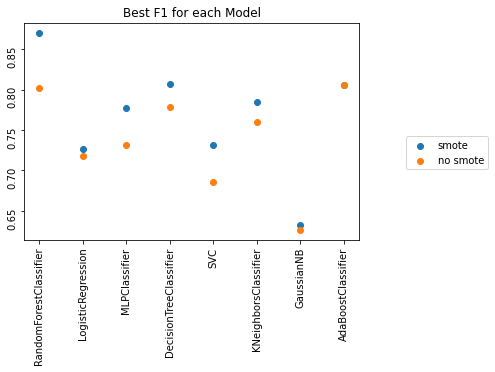

In [181]:
classifiers = list(bestModels['classifier'].unique())
f1s         = list(bestModels['avgF1'].astype(float).unique())
classifiers2 = list(bestModelsNo['classifier'].unique())
f1s2         = list(bestModelsNo['avgF1'].astype(float).unique())
fig,ax=plt.subplots()
ax.scatter(classifiers,f1s,label='smote')
ax.scatter(classifiers2,f1s2,label='no smote')
ax.tick_params(rotation=90)
ax.set(title='Best F1 for each Model')
ax.legend(bbox_to_anchor=(1.4,0.5))

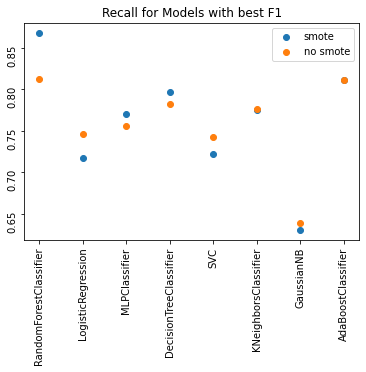

In [178]:
classifiers = list(bestModels['classifier'].unique())
f1s         = list(bestModels['avgRecall'].astype(float).unique())
classifiers2 = list(bestModelsNo['classifier'].unique())
f1s2         = list(bestModelsNo['avgRecall'].astype(float).unique())
fig,ax=plt.subplots()
ax.scatter(classifiers,f1s,label='smote')
ax.scatter(classifiers2,f1s2,label='no smote')
ax.tick_params(rotation=90)
ax.set(title='Recall for Models with best F1')
ax.legend()

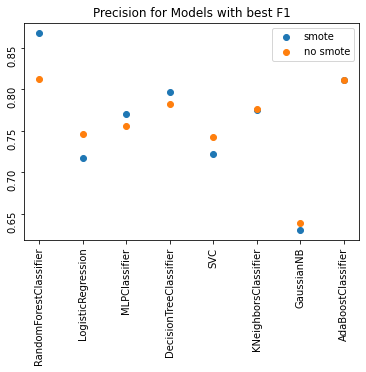

In [179]:
classifiers = list(bestModels['classifier'].unique())
f1s         = list(bestModels['avgPrecision'].astype(float).unique())
classifiers2 = list(bestModelsNo['classifier'].unique())
f1s2         = list(bestModelsNo['avgPrecision'].astype(float).unique())
fig,ax=plt.subplots()
ax.scatter(classifiers,f1s,label='smote')
ax.scatter(classifiers2,f1s2,label='no smote')
ax.tick_params(rotation=90)
ax.set(title='Precision for Models with best F1')
ax.legend()

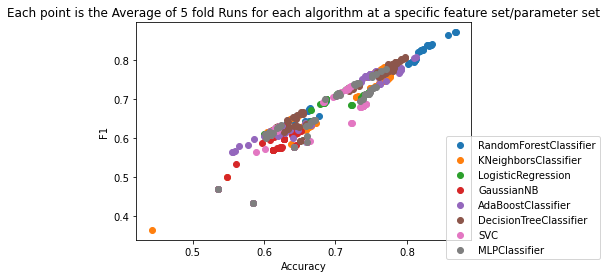

In [180]:
fig,ax=plt.subplots()
for classifier in modelCompare['classifier'].unique():
    subdf = modelCompare[modelCompare['classifier']==classifier]
    ax.scatter(subdf['avgAccuracy'],subdf['avgF1'],label=classifier)
ax.set(xlabel='Accuracy',ylabel='F1',title='Each point is the Average of 5 fold Runs for each algorithm at a specific feature set/parameter set')
ax.legend(bbox_to_anchor=(1.4,0.5))

In [ ]:
classifiers = list(bestModels[bestModels]['classifier'].unique())
f1s         = list(bestModels['avgF1'].astype(float).unique())
classifiers2 = list(bestModelsNo['classifier'].unique())
f1s2         = list(bestModelsNo['avgF1'].astype(float).unique())
fig,ax=plt.subplots()
ax.scatter(classifiers,f1s,label='smote')
ax.scatter(classifiers2,f1s2,label='no smote')
ax.tick_params(rotation=90)
ax.set(title='Best F1 for each Model')
ax.legend(bbox_to_anchor=(1.4,0.5))

[Text(0.5, 1.0, 'Best SMOTE vs Best No Smote Models for Random Forest (the best out of all models)')]

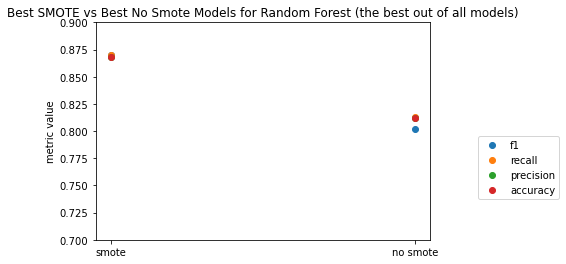

In [198]:
bestRf = pd.merge( modelCompare,
modelCompare[modelCompare['classifier']=='RandomForestClassifier'].groupby(['smote','classifier'])['avgF1'].max().reset_index(),
on = ['classifier','avgF1'])

fig,ax= plt.subplots()

ax.scatter(bestRf['smote_x'],bestRf['avgF1'],label='f1')
ax.scatter(bestRf['smote_x'],bestRf['avgRecall']+0.001,label='recall')
ax.scatter(bestRf['smote_x'],bestRf['avgPrecision'],label='precision')
ax.scatter(bestRf['smote_x'],bestRf['avgAccuracy'],label='accuracy')
ax.set(ylabel='metric value')
ax.legend(bbox_to_anchor=(1.4,0.5))
ax.set(ylim=[0.7,0.9])
ax.set(title='Best SMOTE vs Best No Smote Models for Random Forest (the best out of all models)')

In [199]:
bestRf

,classifier,avgAccuracy,avgF1,avgPrecision,avgRecall,smote_x,smote_y
0,RandomForestClassifier,0.868524,0.870393,0.868524,0.868524,smote,smote
1,RandomForestClassifier,0.812100,0.801818,0.812100,0.812100,no smote,no smote


In [ ]:
'''

acc          
recall
f1
precision

'''

[(0.8, 0.9)]

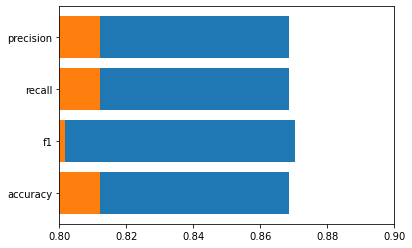

In [205]:
fig,ax=plt.subplots()
ax.barh(['accuracy','f1','recall','precision'],
        [0.868524,0.870393,0.868524,0.868524],label='smote')
ax.set(xlim=[0.8,0.9])
ax.barh(['accuracy','f1','recall','precision'],
        [0.812100,0.801818,0.812100,0.812100],label='smote')
ax.set(xlim=[0.8,0.9])